In [1]:
# If you want the figures to appear in the notebook, 
# and you want to interact with them, use
# %matplotlib notebook

# If you want the figures to appear in the notebook, 
# and you don't want to interact with them, use
# %matplotlib inline

# If you want the figures to appear in separate windows, use
# %matplotlib qt5

# To switch from one to another, you have to select Kernel->Restart

%matplotlib inline

from modsim import *

In [2]:
init = State(S=89, I=1, R=0, Q=0)
init

,value
S,89
I,1
R,0
Q,0


In [3]:
init /= sum(init)
init

,value
S,0.988889
I,0.011111
R,0.000000
Q,0.000000


In [29]:
def make_system(beta, gamma,omega,t_end):
    """Make a system object for the SIR model.
    
    beta: contact rate in days
    gamma: recovery rate in days
    
    returns: System object
    """
    init = State(S=89, I=1, R=0, Q=0)
    init /= sum(init)

    t0 = 0
    

    return System(init=init, t0=t0, 
                  beta=beta, gamma=gamma, omega=omega, t_end=t_end)

In [107]:
tc = 0.35      # time between contacts in days 
tr = 2  # Infectious period in days
tq =4 # recovery time in days
t_end=20
beta = 1 / tc      # contact rate in per day
gamma = 1 / tr 
omega = 1/tq  # recovery rate in per day

system = make_system(beta, gamma,omega,t_end)

In [130]:
def update1(state, system):
    """Update the SIR model.
    
    state: State with variables S, I, R
    system: System with beta and gamma
    
    returns: State object
    """
    s, i, r, q = state

    infected = system.beta * i * s    
    quarentine = system.gamma * i
    recovered = system.omega * q 
    
    s -= infected
    i += infected - quarentine
    q += quarentine- recovered
    r += recovered
    
    return State(S=s, I=i, R=r, Q=q)

In [131]:
state = update1(init, system)
state

,value
S,0.957496
I,0.039727
R,0.000000
Q,0.002778


In [132]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
    
    system: System object
    update_func: function that updates state
    
    returns: State object for final state
    """
    state = system.init
    for t in linrange(system.t0, system.t_end):
        state = update_func(state, system)
    return state

In [133]:
run_simulation(system, update1)

,value
S,-0.000003
I,0.006769
R,0.954637
Q,0.038598


In [134]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
    
    Add three Series objects to the System: S, I, R
    
    system: System object
    update_func: function that updates state
    """
    S = TimeSeries()
    I = TimeSeries()
    R = TimeSeries()
    Q=TimeSeries()

    state = system.init
    t0 = system.t0
    S[t0], I[t0], R[t0],Q[t0] = state
    
    for t in linrange(system.t0, system.t_end):
        state = update_func(state, system)
        S[t+1], I[t+1], R[t+1], Q[t+1] = state
    
    system.S = S
    system.I = I
    system.R = R
    system.Q=Q

In [135]:
system.S

,value
0,9.888889e-01
1,9.574956e-01
2,8.488154e-01
3,5.129872e-01
4,-1.314487e-01
5,-4.973265e-01
6,-1.015643e+00
7,-1.725830e+00
8,-4.322634e+00
9,-3.151606e+01


In [136]:
def plot_results(S, I, R,Q):
    """Plot the results of a SIR model.
    
    S: TimeSeries
    I: TimeSeries
    R: TimeSeries
    """
    plot(S, '--', color='blue', label='Susceptible')
    plot(I, '-', color='red', label='Infected')
    plot(R, ':', color='green', label='Recovered')
    plot(Q,':', color='yellow',label='Quarentined')
    decorate(xlabel='Time (days)',
             ylabel='Fraction of population')

Saving figure to file chap05-fig01.pdf


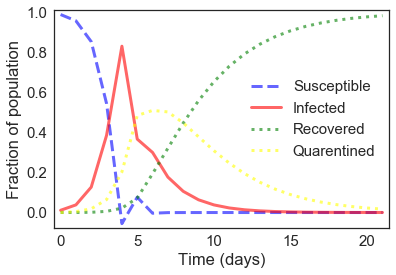

In [139]:
tc = 0.35      # time between contacts in days 
tr = 2.5  # Infectious period in days
tq =4 # recovery time in days
t_end=20
beta = 1 / tc      # contact rate in per day
gamma = 1 / tr 
omega = 1/tq  # recovery rate in per day

system = make_system(beta, gamma,omega,t_end)
run_simulation(system, update1)
plot_results(system.S, system.I, system.R,system.Q)
savefig('chap05-fig01.pdf')

In [103]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
    
    Add a DataFrame to the System: results
    
    system: System object
    update_func: function that updates state
    """
    frame = DataFrame(columns=system.init.index)
    frame.loc[system.t0] = system.init
    
    for t in linrange(system.t0, system.t_end):
        frame.loc[t+1] = update_func(frame.loc[t], system)
    
    system.results = frame

In [106]:
tc = 3      # time between contacts in days 
tr = 4      # recovery time in days
tq=4
beta = 1 / tc      # contact rate in per day
gamma = 1 / tr  
omega=1/tq# recovery rate in per day
t_end=15

sir = make_system(beta, gamma,omega,t_end)
run_simulation(system, update1)
system.results.head()

,S,I,R,Q
0,0.988889,0.011111,0.000000,0.000000
1,0.957496,0.038801,0.000000,0.003704
2,0.851348,0.132014,0.000926,0.015711
3,0.530234,0.409124,0.004854,0.055788
4,-0.089571,0.892554,0.018801,0.178216


In [105]:
frame = system.results
plot_results(frame.S, frame.I, frame.R,frame.Qdef calc_total_infected(system):
    """Fraction of population infected during the simulation.
    
    system: System object with results.
    
    returns: fraction of population
    """
    frame = system.results
    return frame.S[system.t0] - frame.S[system.t_end])

SyntaxError: invalid syntax (<ipython-input-105-fdbf24281142>, line 2)

In [54]:
def calc_total_infected(system):
    """Fraction of population infected during the simulation.
    
    system: System object with results.
    
    returns: fraction of population
    """
    frame = system.results
    return frame.S[system.t0] - frame.S[system.t_end]

In [55]:
system.beta = 3
system.gamma = 0.25
run_simulation(system, update1)
print(system.beta, system.gamma, calc_total_infected(system))

3 0.25 0.988867604902


In [56]:
def fraction_sick_at_peak(system):
    frame = system.results
    return frame.I.max()

In [57]:
def time_of_peak(system):
    frame = system.results
    return frame.I.idxmax()

In [58]:
def sick_at_end(system):
    frame = system.results
    return frame.I[system.t_end]

In [59]:
sick_at_end(system)

0.011939588462316787

In [60]:
def add_immunization(system, fraction1,fraction2):
    """Immunize a fraction of the population.
    
    Moves the given fraction from S to R.
    
    system: System object
    fraction: number from 0 to 1
    """
    system.init.S -= (fraction1*.99)+(fraction2*0.95)
    system.init.R += (fraction1*.99)+(fraction2*0.95)

In [99]:
tc = 0.35     # time between contacts in days 

tr = 3      # infectious  time in days
tq = 4
beta = 1 / tc      # contact rate in per day
gamma = 1 / tr  
omega=1/tq
t_end=15# recovery rate in per day

system = make_system(beta, gamma,omega,t_end)
system.beta, system.gamma

(2.857142857142857, 0.3333333333333333)

In [98]:
run_simulation(system, update1)
calc_total_infected(system)

0.99553146381254443

In [88]:
system2 = make_system(beta, gamma,omega,t_end)
add_immunization(system2, 0.6,0.0)
run_simulation(system2, update1)
calc_total_infected(system2)

0.1361652276344158

Saving figure to file chap05-fig02.pdf


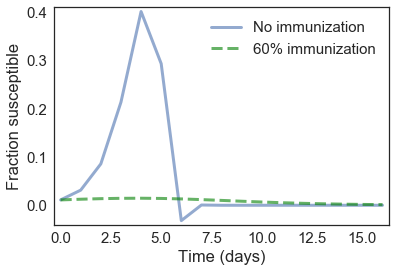

In [89]:
plot(system.results.I, '-', label='No immunization')
plot(system2.results.I, 'g--', label='60% immunization')

decorate(xlabel='Time (days)',
         ylabel='Fraction susceptible')

savefig('chap05-fig02.pdf')

In [90]:
immunize_array = linspace(0.8, 0.97, 11)

for fraction in immunize_array:
    system = make_system(beta, gamma,omega,t_end)
    add_immunization(system, fraction,0)
    run_simulation(system, update1)
    print(fraction, calc_total_infected(system))

0.8 0.0135105110576
0.817 0.0112711559084
0.834 0.00938460884481
0.851 0.00777746637544
0.868 0.00639432476251
0.885 0.00519291950018
0.902 0.00414062575201
0.919 0.00321195551949
0.936 0.00238676316539
0.953 0.00164894873894
0.97 0.000985511226458


In [91]:
def sweep_immunity(immunize_array):
    """Sweeps a range of values for immunity.
    
    immunize_array: array of fraction immunized
    
    returns: Sweep object
    """
    sweep = SweepSeries()
    for fraction in immunize_array:
        system = make_system(beta, gamma,omega,t_end)
        add_immunization(system, fraction,0)
        run_simulation(system, update1)
        sweep[fraction] = calc_total_infected(system)
    return sweep

In [92]:
immunize_array = linspace(0.7, 1, 21)
infected_sweep = sweep_immunity(immunize_array)

Saving figure to file chap05-fig03.pdf


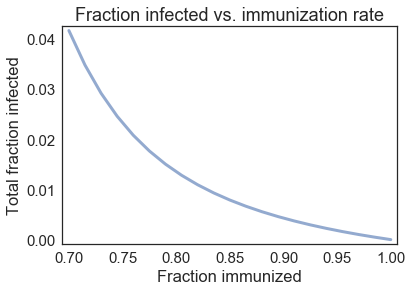

In [93]:
plot(infected_sweep)

decorate(xlabel='Fraction immunized',
         ylabel='Total fraction infected',
         title='Fraction infected vs. immunization rate',
         legend=False)

savefig('chap05-fig03.pdf')

In [94]:
def sweep_immunity1(immunize_array):
    """Sweeps a range of values for immunity.
    
    immunize_array: array of fraction immunized
    
    returns: Sweep object
    """
    sweep = SweepSeries()
    for fraction in immunize_array:
        system = make_system(beta, gamma,omega,t_end)
        add_immunization(system, 0,fraction)
        run_simulation(system, update1)
        sweep[fraction] = calc_total_infected(system)
    return sweep

Saving figure to file chap05-fig03.pdf


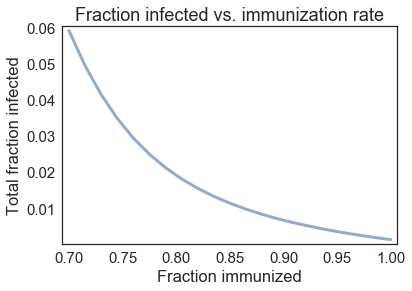

In [95]:
immunize_array = linspace(0.7, 1, 21)
infected_sweep = sweep_immunity1(immunize_array)
plot(infected_sweep)

decorate(xlabel='Fraction immunized',
         ylabel='Total fraction infected',
         title='Fraction infected vs. immunization rate',
         legend=False)

savefig('chap05-fig03.pdf')